In [1]:
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import pathlib
from palettable.wesanderson import Moonrise5_6

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-phncwgvy because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sns.set()

In [3]:
cases = pd.read_csv("data/case_studies.csv")
cases

,case,period,origin
0,Athens,pre-industrial,"(23.729297894645065, 37.977742321097296)"
1,Brugge,pre-industrial,"(3.222135599564842, 51.20663413385126)"
2,Havana,pre-industrial,"(-82.35387869733259, 23.137058811383366)"
3,Kyoto,pre-industrial,"(135.77513789847612, 35.00441991880096)"
4,Nuremberg,pre-industrial,"(11.080741895925831, 49.4558122318182)"
5,Pavia,pre-industrial,"(9.155202505665285, 45.18542787308676)"
6,Recife,pre-industrial,"(-34.87950134898907, -8.066819977715335)"
7,Barcelona,industrial,"(2.1599658311051333, 41.39207228345335)"
8,Brisbane,industrial,"(153.00890689998246, -27.483072513877765)"
9,Buenos Aires,industrial,"(-58.37436109734774, -34.618526518125655)"


In [4]:
cases = cases.set_index("case")

In [5]:
files = glob.glob("data/*gpkg")

In [6]:
data = pd.DataFrame()

In [7]:
for f in files:
    tessellation = gpd.read_file(f, layer="tessellation")
    case = pathlib.Path(f).stem
    coords = cases.origin.loc[case]
    buffer = gpd.GeoSeries([Point(tuple(map(float, coords[1:-1].split(', '))))], crs=4326).to_crs(tessellation.crs).buffer(400)
    tessellation['period'] = cases.period.loc[case]
    tessellation['case'] = case
    casegdf = tessellation[tessellation.centroid.within(buffer.iloc[0])]
    data = data.append(casegdf.drop(columns=["uID", "nID", "mm_len", "node_start", "node_end", "nodeID", "geometry"]))

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [8]:
data['period'] = pd.Categorical(data['period'], categories=['pre-industrial', 'industrial', 'garden city', 'modernist', 'neo-traditional', 'informal'], ordered=True)

In [9]:
data = data.sort_values('period').reset_index(drop=True)

In [72]:
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette(Moonrise5_6.hex_colors)

In [87]:
for ch in data.columns.drop(['case', 'period']):
    plt.figure(figsize=(12, 8))
    boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
    boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f"figures/{ch}_all_normal.png", bbox_inches="tight")
    plt.close("all")
    
    plt.figure(figsize=(12, 8))
    boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
    boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
    boxen.set_yscale("log")
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f"figures/{ch}_all_log.png", bbox_inches="tight")
    plt.close("all")

In [88]:
for ch in data.columns.drop(['case', 'period']):
    plt.figure(figsize=(12, 8))
    box = sns.boxplot(x="period", y=ch,dodge=False, data=data, showfliers=False)
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f"figures/{ch}_grouped_normal.png", bbox_inches="tight")
    plt.close("all")
    
    plt.figure(figsize=(12, 8))
    box = sns.boxplot(x="period", y=ch,dodge=False, data=data, showfliers=False)
    box.set_yscale("log")
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f"figures/{ch}_grouped_log.png", bbox_inches="tight")
    plt.close("all")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

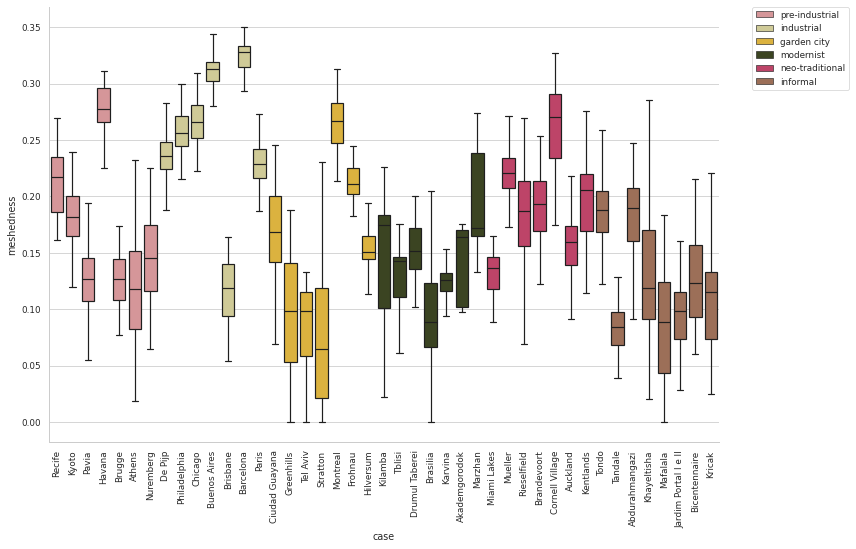

In [86]:
plt.figure(figsize=(12, 8))
boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
sns.despine()
